# 消費者分群
## 使用 [電商零售資料集](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data)
這個計畫目的在於替消費者分群，利用主要購買的商品種類區分消費者族群，找出消費行為之間的相同與不同之處，以利廠商擬定行銷策略。  
其中會使用到的工具:  
+ 主成分分析 (Principle Component Analysis)  
+ K平均演算法 (K-means clustering)  
+ 先驗演算法 (Apriori  Algorithm)  

In [2]:
# 載入套件
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
aisles = pd.read_csv('D:/JupyterWorkspace/project/data/aisles.csv')
order_products_train = pd.read_csv('D:/JupyterWorkspace/project/data/order_products__train.csv')
order_products_prior = pd.read_csv('D:/JupyterWorkspace/project/data/order_products__prior.csv')
orders = pd.read_csv('D:/JupyterWorkspace/project/data/orders.csv')
products = pd.read_csv('D:/JupyterWorkspace/project/data/products.csv')
departments = pd.read_csv('D:/JupyterWorkspace/project/data/departments.csv')

## 資料探索

In [4]:
# 商品種類
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
# 消費者最後一次消費所購買的項目
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
# 每位消費者先前的訂單所購買的商品
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
# 每位消費者的訂單紀錄
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
# 各項商品資料
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
# 商品所屬部門資料
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### 消費者消費次數的分布狀況

In [10]:
consumption_times = orders.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
consumption_times = consumption_times.order_number.value_counts()


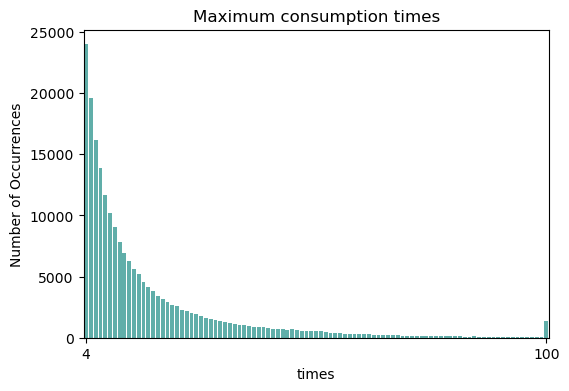

In [11]:
color='#28aaa2'
plt.figure(figsize=(6,4))
sns.barplot(x=consumption_times.index, y=consumption_times.values, alpha=0.8, color=color)
plt.title('Maximum consumption times')
plt.xlabel('times')
plt.ylabel('Number of Occurrences')
plt.xticks([0,96])
plt.show()

消費者消費次數分布從4次到100次，4次最多，呈現遞減趨勢

### 一周之中下單數分布狀況

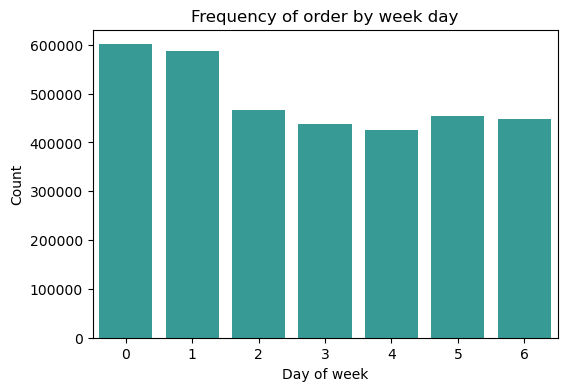

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x='order_dow', data=orders, color=color)
plt.title("Frequency of order by week day")
plt.xlabel('Day of week')
plt.ylabel('Count')
plt.show()

資料中沒有提到0到6分別代表星期幾，但我們推測下單數最多的兩天可能是週六和週日

### 一天之中下單數分布

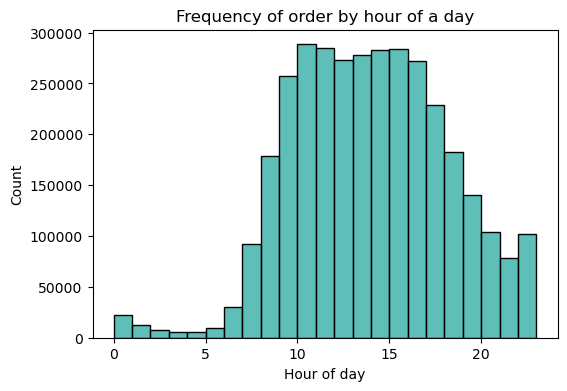

In [13]:
plt.figure(figsize=(6,4))
sns.histplot(x='order_hour_of_day', data=orders, color=color, binwidth=1)
plt.title('Frequency of order by hour of a day')
plt.xlabel('Hour of day')
plt.ylabel('Count')
plt.show()

每天的下單時間集中白天，10到16點之間

In [14]:
# 製作新的data frame，內容包含幾乎所有訊息
# 因資料集龐大，隨機抽取60%的資料來進行後續分析
order_products_prior=order_products_prior.sample(frac=0.6,random_state=2023)
merged_df=pd.merge(order_products_prior, products, on=['product_id','product_id'])
merged_df=pd.merge(merged_df, orders, on=['order_id','order_id'])
merged_df=pd.merge(merged_df, aisles, on=['aisle_id','aisle_id'])
merged_df.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2713314,24799,2,1,Vanilla Skyr Nonfat Yogurt,120,16,202484,prior,29,0,11,8.0,yogurt
1,2713314,12745,1,1,"Yogurt, Lowfat, Strawberry",120,16,202484,prior,29,0,11,8.0,yogurt
2,2713314,39160,5,1,Kefir Cultured Strawberry Milk Drink,120,16,202484,prior,29,0,11,8.0,yogurt
3,2124951,24799,6,1,Vanilla Skyr Nonfat Yogurt,120,16,26825,prior,6,5,9,30.0,yogurt
4,2124951,13263,2,1,Non Fat Acai & Mixed Berries Yogurt,120,16,26825,prior,6,5,9,30.0,yogurt


In [15]:
merged_df.shape

(19460693, 14)

### 最熱銷的前20個商品種類

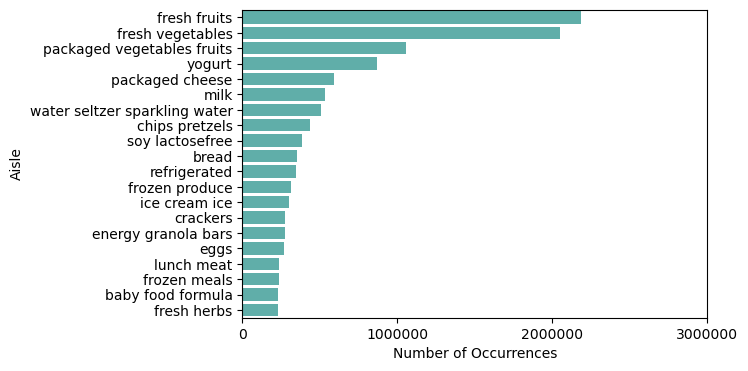

In [16]:
aisle_freq = merged_df.aisle.value_counts().head(20)
plt.figure(figsize=(6,4))
sns.barplot(y=aisle_freq.index, x=aisle_freq.values, alpha=0.8, color=color)
plt.xlabel('Number of Occurrences')
plt.ylabel('Aisle')
plt.xticks(np.arange(0,4000000,1000000),list(map(str,np.arange(0,4000000,1000000))))
plt.show()

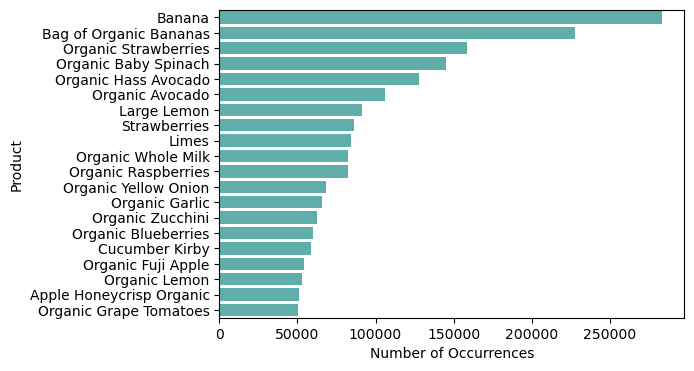

In [17]:
product_freq = merged_df.product_name.value_counts().head(20)
plt.figure(figsize=(6,4))
sns.barplot(y=product_freq.index, x=product_freq.values, alpha=0.8, color=color)
plt.xlabel('Number of Occurrences')
plt.ylabel('Product')
plt.show()

## 消費者分群

In [18]:
user_aisle_ct = pd.crosstab(merged_df.user_id, merged_df.aisle)
user_aisle_ct

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,0,0,0,0,...,2,1,1,0,0,0,0,2,0,24
3,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
206206,0,3,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
206207,0,0,0,0,0,0,0,0,0,0,...,2,4,0,1,0,0,0,7,0,12


先做主成分分析(PCA)把特徵濃縮到6個

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(user_aisle_ct)
pca_table=pd.DataFrame(pca.transform(user_aisle_ct))
pca_table

,0,1,2,3,4,5
0,-13.076356,2.210122,-2.456729,0.996272,0.184459,-0.662494
1,4.735628,21.524475,2.825626,10.278966,-4.516620,0.925889
2,-3.913079,1.238315,-7.269972,1.166480,-1.142506,-0.485158
3,-16.206596,-0.117497,-1.656095,1.101681,-0.311881,0.760908
4,-11.447604,-3.614298,0.846726,1.996239,0.288908,-0.313293
...,...,...,...,...,...,...
206145,-14.896665,-0.620920,0.926375,2.402013,0.144133,0.207869
206146,-5.514802,-0.065027,3.468304,-11.629086,0.762141,-6.633111
206147,3.016651,7.025401,8.060719,-2.389345,0.694949,-1.209246
206148,52.425129,9.060750,8.643734,-7.150153,6.212245,-20.285310


In [20]:
# 六個主成分分別解釋了多少變異
pca.explained_variance_ratio_

array([0.47267057, 0.09519144, 0.05244959, 0.0357636 , 0.02899945,
       0.02400682])

Text(0, 0.5, 'cumulated explained variance')

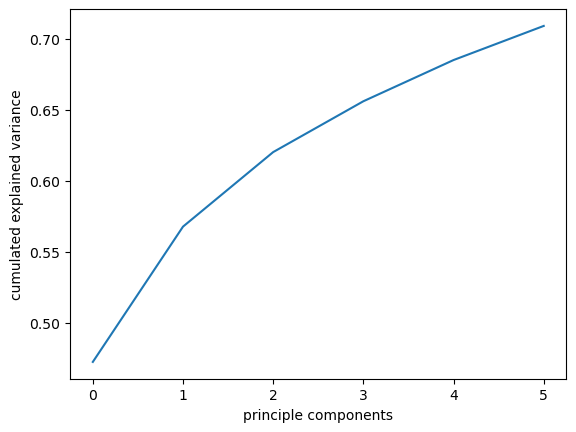

In [21]:
# 主成分解釋的變異累積圖
c_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(c_explained_variance_ratio)
plt.xlabel('principle components')
plt.ylabel('cumulated explained variance')

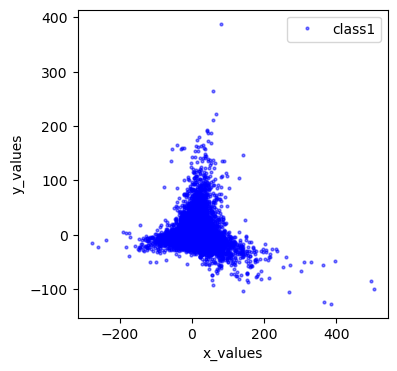

In [22]:
tocluster = pd.DataFrame(pca_table[[1,4]])

fig = plt.figure(figsize=(4,4))
plt.plot(tocluster[1], tocluster[4], 'o', markersize=2, color='blue', alpha=0.5, label='class1')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

### 利用elbow-method找出可能的分群數

Text(0.5, 1.0, 'KMeans elbow w/t Age')

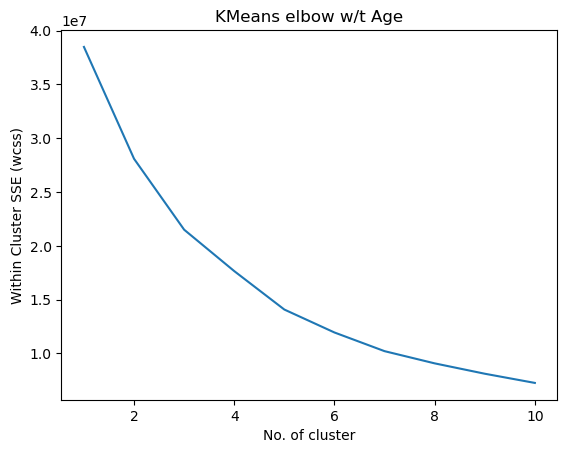

In [23]:
wcss = [] #within-cluster sum of squares
from sklearn.cluster import KMeans
for i in range(1,11): #跑10輪
    model = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 2023)
    model.fit(tocluster)
    wcss.append(model.inertia_)
    
fig,ax = plt.subplots()
sns.lineplot(x = list(range(1,11)), y = wcss, ax = ax)
ax.set_xlabel('No. of cluster')
ax.set_ylabel('Within Cluster SSE (wcss)')
ax.set_title('KMeans elbow w/t Age')

依照elbow-method的結果可看出，可能的群數是3或5，但經過實驗後，我認為分成5群有較好的結果

In [24]:
#用KMeans將消費者分成5群並找出群中點
kmeans = KMeans(n_clusters=5,random_state=2023).fit(tocluster)
centers = kmeans.cluster_centers_
c_preds = kmeans.predict(tocluster)
print(centers)

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[-8.34321922e-01 -8.88643635e-03]
 [ 8.52234414e+01 -1.95720929e+01]
 [ 1.63768975e+01  4.81155893e+01]
 [ 1.83422344e+01 -1.83662995e+00]
 [-2.65438055e+01 -3.07346218e+00]]


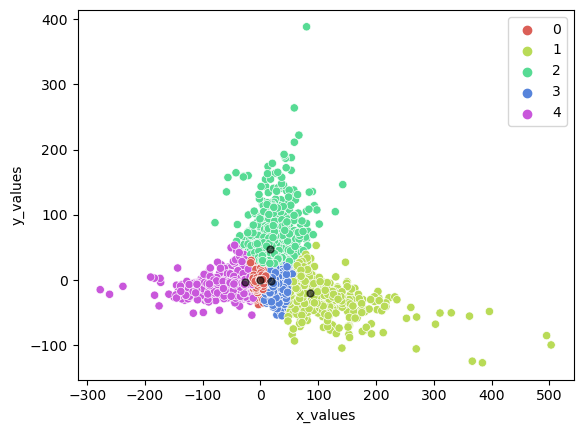

In [25]:
fig = plt.figure()
sns.scatterplot(
    x=tocluster[1],
    y=tocluster[4],
    hue=c_preds,
    palette = sns.color_palette('hls', 5)
)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=5, color='black', alpha=0.6)

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

試著找出新的觀點與模式

In [26]:
clustering_of_5_ct=user_aisle_ct.copy()
clustering_of_5_ct['cluster']=c_preds
clustering_of_5_ct.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,3,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,2,0,24,3
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


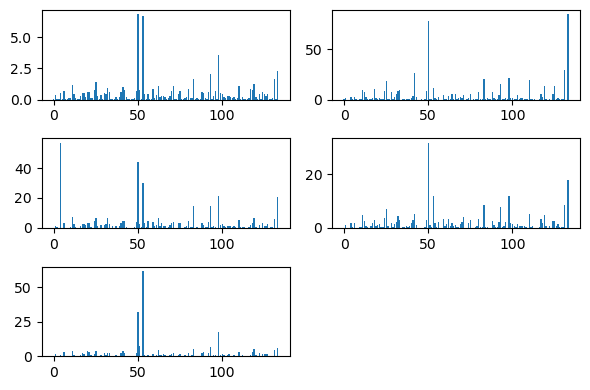

In [27]:
fig,axs = plt.subplots(3,2,figsize=(6,4))
feats=len(clustering_of_5_ct.drop('cluster',axis=1).columns)
c0 = clustering_of_5_ct[clustering_of_5_ct.cluster==0].drop('cluster',axis=1).mean()
axs[0,0].bar(range(feats),c0)
c1 = clustering_of_5_ct[clustering_of_5_ct.cluster==1].drop('cluster',axis=1).mean()
axs[0,1].bar(range(feats),c1)
c2 = clustering_of_5_ct[clustering_of_5_ct.cluster==2].drop('cluster',axis=1).mean()
axs[1,0].bar(range(feats),c2)
c3 = clustering_of_5_ct[clustering_of_5_ct.cluster==3].drop('cluster',axis=1).mean()
axs[1, 1].bar(range(feats),c3)
c4 = clustering_of_5_ct[clustering_of_5_ct.cluster==4].drop('cluster',axis=1).mean()
axs[2, 0].bar(range(feats),c4)
plt.delaxes()
plt.tight_layout()
plt.show()

In [28]:
c0.sort_values(ascending=False)[:10]

aisle
fresh fruits                     6.831679
fresh vegetables                 6.731519
packaged vegetables fruits       3.596434
yogurt                           2.272428
packaged cheese                  2.010232
milk                             1.685888
water seltzer sparkling water    1.622620
chips pretzels                   1.438705
soy lactosefree                  1.267371
bread                            1.205404
dtype: float64

In [29]:
c1.sort_values(ascending=False)[:10]

aisle
yogurt                           85.063330
fresh fruits                     78.798774
water seltzer sparkling water    29.993871
energy granola bars              26.617978
packaged vegetables fruits       21.362615
milk                             20.526047
refrigerated                     19.504597
chips pretzels                   19.009193
packaged cheese                  16.044944
tea                              14.029622
dtype: float64

In [30]:
c2.sort_values(ascending=False)[:10]

aisle
baby food formula             56.964734
fresh fruits                  43.717274
fresh vegetables              29.975493
packaged vegetables fruits    21.209803
yogurt                        20.420801
packaged cheese               14.696952
milk                          14.506276
bread                          7.424387
crackers                       6.893007
chips pretzels                 6.852959
dtype: float64

In [31]:
c3.sort_values(ascending=False)[:10]

aisle
fresh fruits                     31.682049
yogurt                           17.933008
packaged vegetables fruits       11.964617
fresh vegetables                 11.674502
milk                              8.614376
water seltzer sparkling water     8.370531
packaged cheese                   7.823890
chips pretzels                    6.969133
refrigerated                      5.305518
energy granola bars               5.292156
dtype: float64

In [32]:
c4.sort_values(ascending=False)[:10]

aisle
fresh vegetables                 61.993132
fresh fruits                     31.818042
packaged vegetables fruits       17.395695
fresh herbs                       7.184521
packaged cheese                   6.570989
yogurt                            6.153972
soy lactosefree                   5.556330
milk                              5.183598
frozen produce                    4.881394
water seltzer sparkling water     4.262737
dtype: float64

這裡我們可以看到第0,3,4群的消費者購買的商品種類，與先前得到的熱銷排行前10商品，大致相同，只有排名的順序稍有不同  
熱銷排名前10商品:  
+ fresh fruits  
+ fresh vegetables  
+ packaged vegetables fruits  
+ yogurt  
+ packaged cheese  
+ milk  
+ water seltzer sparkling water  
+ chips pretzels  
+ soy lactosefree  
+ bread   

另外可以觀察到第2群消費者，他們購買較多baby food formula，而第1群消費者的購物清單中，tea也排在前10大類，這兩個商品種類都是整體熱銷排行前10以外的商品

## 關聯分析

Association Rules關聯規則三大指標:  
* Support: 支持度，某item-set在資料庫中出現的頻率  
support(x->y) = p(x,y)，其中x->y表示一條規則  
用法: 設定最小支持度作為篩選條件  

* Confidence: 信賴度，兩項目集之間的條件機率    
越高表示該關聯性規則具有高度關係  
用法: 設定最小信賴度作為篩選條件  

* Lift: 提升度，信賴度與y項目發生機率的比  
判斷兩項目集的相關程度，若小於1表示負相關，等於1表示完全無相關（完全沒有交集），大於1表示正相關

以下將產出每群消費者的關聯分析表，幫助廠商建立推薦系統給不同群消費者

In [33]:
#把內容最齊全的data frame(merged_df)加上消費者分群結果
user_cluster_ct=clustering_of_5_ct.drop(columns=clustering_of_5_ct.columns[:-1],inplace=False)
merged_df=pd.merge(user_cluster_ct,merged_df,on=['user_id','user_id'])
merged_df.shape

(19460693, 15)

In [54]:
#用分群結果切割這個data frame
c0_merged_df=merged_df[merged_df.cluster==0]
c1_merged_df=merged_df[merged_df.cluster==1]
c2_merged_df=merged_df[merged_df.cluster==2]
c3_merged_df=merged_df[merged_df.cluster==3]
c4_merged_df=merged_df[merged_df.cluster==4]

In [35]:
#定義抽樣函數，抽各群消費者訂單中的10000筆
random.seed(2023)
def rand_sample_df(df):    
    rnd_list=random.sample(list(np.unique(df.order_id)),10000)
    rnd_list.sort()
    for i in rnd_list:
        rnd_i=df[df.order_id==i]
        if i == min(rnd_list):
            rnd_df=rnd_i
        if i != min(rnd_list):
            rnd_df=rnd_df.append(rnd_i)
    return rnd_df

In [36]:
#encoding函數
def freq_encoder(i):
    if i == 0:
        return 0
    if i > 0:
        return 1

In [49]:
#第0群消費者樣本訂單購買的品項紀錄
rnd_df=rand_sample_df(c0_merged_df)
rnd_df = rnd_df.loc[:,['order_id','product_name']]
rnd_df.columns = ['order','item']
rnd_df['temp'] = 1
rnd_df=rnd_df.groupby(['order','item'])['temp'].sum().unstack().fillna(0)
rnd_df.applymap(freq_encoder)

item,#2 Coffee Filters,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Organic Greek Vanilla Yogurt,0% Greek Strained Yogurt,0% Greek Yogurt Black Cherry on the Bottom,1 % Lowfat Milk,1 Apple + 1 Mango Fruit Bar,1 Liter,1 Ply Paper Towels,...,"\""Constant Comment\"" Green Tea Blend Tea Bags","\""Mokaccino\"" Milk + Blue Bottle Coffee Chocolate",for Tots Apple Juice,gel hand wash sea minerals,of Hanover 100 Calorie Pretzels Mini,smartwater® Electrolyte Enhanced Water,vitaminwater® XXX Acai Blueberry Pomegranate,with Crispy Almonds Cereal,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing
order,,,,,,,,,,,,,,,,,,,,,
119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3420422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3420444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 建立模型

In [38]:
import mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

In [62]:
freq_itemset = apriori(rnd_df, min_support = 0.005, use_colnames = True)
freq_itemset

,support,itemsets
0,0.0070,(100% Raw Coconut Water)
1,0.0098,(100% Whole Wheat Bread)
2,0.0061,(2% Reduced Fat Milk)
3,0.0119,(Apple Honeycrisp Organic)
4,0.0134,(Asparagus)
...,...,...
119,0.0137,(Yellow Onions)
120,0.0050,"(Organic Baby Spinach, Bag of Organic Bananas)"
121,0.0058,"(Organic Strawberries, Bag of Organic Bananas)"
122,0.0058,"(Banana, Organic Avocado)"


In [63]:
#設定association rule
rules = association_rules(freq_itemset, metric = 'lift', min_threshold = 1)
rules.sort_values(by = 'confidence', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,(Strawberries),(Banana),0.0266,0.0808,0.0055,0.206767,2.558997,0.003351,1.158802
5,(Organic Avocado),(Banana),0.0296,0.0808,0.0058,0.195946,2.425074,0.003408,1.143207
2,(Organic Strawberries),(Bag of Organic Bananas),0.0395,0.0648,0.0058,0.146835,2.265979,0.003240,1.096154
0,(Organic Baby Spinach),(Bag of Organic Bananas),0.0459,0.0648,0.0050,0.108932,1.681057,0.002026,1.049528
3,(Bag of Organic Bananas),(Organic Strawberries),0.0648,0.0395,0.0058,0.089506,2.265979,0.003240,1.054922
1,(Bag of Organic Bananas),(Organic Baby Spinach),0.0648,0.0459,0.0050,0.077160,1.681057,0.002026,1.033874
4,(Banana),(Organic Avocado),0.0808,0.0296,0.0058,0.071782,2.425074,0.003408,1.045444
6,(Banana),(Strawberries),0.0808,0.0266,0.0055,0.068069,2.558997,0.003351,1.044498


In [40]:
#分析第1群消費者
rnd_df=rand_sample_df(c1_merged_df)
rnd_df = rnd_df.loc[:,['order_id','product_name']]
rnd_df.columns = ['order','item']
rnd_df['temp'] = 1
rnd_df=rnd_df.groupby(['order','item'])['temp'].sum().unstack().fillna(0)
rnd_df.applymap(freq_encoder)
freq_itemset = apriori(rnd_df, min_support = 0.005, use_colnames = True)
freq_itemset

C:\Users\jeff\AppData\Roaming\Python\Python38\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.0065,(1% Lowfat Milk)
1,0.0083,(100 Calorie Per Bag Popcorn)
2,0.0180,(100% Raw Coconut Water)
3,0.0062,(100% Recycled Paper Towels)
4,0.0170,(100% Whole Wheat Bread)
...,...,...
371,0.0081,(Total 2% Greek Strained Yogurt with Cherry 5....
372,0.0130,(Total 2% Lowfat Greek Strained Yogurt with Pe...
373,0.0159,(Total 2% with Strawberry Lowfat Greek Straine...
374,0.0134,(Total 2% with Strawberry Lowfat Greek Straine...


In [46]:
rules = association_rules(freq_itemset, metric = 'lift', min_threshold = 1)
rules.sort_values(by = 'confidence', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
143,(Sparkling Water Berry),(Sparkling Water Grapefruit),0.0232,0.0641,0.0111,0.478448,7.464092,0.009613,1.794453
30,(Gala Apples),(Banana),0.0131,0.1773,0.0060,0.458015,2.583278,0.003677,1.517939
132,(Peach Pear Flavored Sparkling Water),(Sparkling Water Grapefruit),0.0222,0.0641,0.0096,0.432432,6.746216,0.008177,1.648967
26,(Bartlett Pears),(Banana),0.0168,0.1773,0.0072,0.428571,2.417211,0.004221,1.439725
96,(Vanilla Skyr Nonfat Yogurt),(Icelandic Style Skyr Blueberry Non-fat Yogurt),0.0283,0.0334,0.0112,0.395760,11.849093,0.010255,1.599695
...,...,...,...,...,...,...,...,...,...
59,(Banana),(Original Hummus),0.1773,0.0292,0.0054,0.030457,1.043043,0.000223,1.001296
46,(Banana),(Organic D'Anjou Pears),0.1773,0.0255,0.0054,0.030457,1.194386,0.000879,1.005113
71,(Banana),(Total 2% Greek Strained Yogurt with Cherry 5....,0.1773,0.0280,0.0052,0.029329,1.047458,0.000236,1.001369
67,(Banana),(Total 0% with Honey Nonfat Greek Strained Yog...,0.1773,0.0274,0.0052,0.029329,1.070395,0.000342,1.001987


In [48]:
#分析第2群消費者
rnd_df=rand_sample_df(c2_merged_df)
rnd_df = rnd_df.loc[:,['order_id','product_name']]
rnd_df.columns = ['order','item']
rnd_df['temp'] = 1
rnd_df=rnd_df.groupby(['order','item'])['temp'].sum().unstack().fillna(0)
rnd_df.applymap(freq_encoder)
freq_itemset = apriori(rnd_df, min_support = 0.005, use_colnames = True)
freq_itemset

C:\Users\jeff\AppData\Roaming\Python\Python38\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.0054,(1% Lowfat Milk)
1,0.0098,(100% Raw Coconut Water)
2,0.0101,(100% Recycled Paper Towels)
3,0.0210,(100% Whole Wheat Bread)
4,0.0058,(2% Reduced Fat DHA Omega-3 Reduced Fat Milk)
...,...,...
378,0.0051,"(Organic Strawberries, Organic Large Extra Fan..."
379,0.0067,(Stage 1 Apples Sweet Potatoes Pumpkin & Blueb...
380,0.0089,"(Organic Raspberries, Organic Strawberries)"
381,0.0093,"(Organic Strawberries, Organic Whole Milk)"


In [49]:
rules = association_rules(freq_itemset, metric = 'lift', min_threshold = 1)
rules.sort_values(by = 'confidence', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
85,"(Organic Pears, Peas and Broccoli Puree Stage 1)",(Stage 1 Apples Sweet Potatoes Pumpkin & Blueb...,0.0212,0.0242,0.0067,0.316038,13.059411,0.006187,1.426687
21,(Organic Half & Half),(Bag of Organic Bananas),0.0195,0.1254,0.0055,0.282051,2.249213,0.003055,1.218193
17,(Organic D'Anjou Pears),(Bag of Organic Bananas),0.0251,0.1254,0.0070,0.278884,2.223959,0.003852,1.212843
84,(Stage 1 Apples Sweet Potatoes Pumpkin & Blueb...,"(Organic Pears, Peas and Broccoli Puree Stage 1)",0.0242,0.0212,0.0067,0.276860,13.059411,0.006187,1.353541
25,(Organic Large Extra Fancy Fuji Apple),(Bag of Organic Bananas),0.0278,0.1254,0.0073,0.262590,2.094019,0.003814,1.186043
...,...,...,...,...,...,...,...,...,...
18,(Bag of Organic Bananas),(Organic Gala Apples),0.1254,0.0243,0.0053,0.042265,1.739290,0.002253,1.018758
13,(Bag of Organic Bananas),(Organic Blueberries),0.1254,0.0342,0.0053,0.042265,1.235811,0.001011,1.008421
39,(Banana),(Honeycrisp Apple),0.1268,0.0227,0.0053,0.041798,1.841326,0.002422,1.019931
5,(Bag of Organic Bananas),(Baby Food Stage 2 Blueberry Pear & Purple Car...,0.1254,0.0306,0.0052,0.041467,1.355141,0.001363,1.011337


In [50]:
#分析第3群消費者
rnd_df=rand_sample_df(c3_merged_df)
rnd_df = rnd_df.loc[:,['order_id','product_name']]
rnd_df.columns = ['order','item']
rnd_df['temp'] = 1
rnd_df=rnd_df.groupby(['order','item'])['temp'].sum().unstack().fillna(0)
rnd_df.applymap(freq_encoder)
freq_itemset = apriori(rnd_df, min_support = 0.005, use_colnames = True)
freq_itemset

C:\Users\jeff\AppData\Roaming\Python\Python38\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.0079,(0% Greek Strained Yogurt)
1,0.0073,(100% Raw Coconut Water)
2,0.0164,(100% Whole Wheat Bread)
3,0.0103,(2% Reduced Fat Milk)
4,0.0234,(Apple Honeycrisp Organic)
...,...,...
159,0.0064,"(Seedless Red Grapes, Banana)"
160,0.0086,"(Strawberries, Banana)"
161,0.0050,"(Organic Hass Avocado, Organic Strawberries)"
162,0.0054,"(Organic Raspberries, Organic Strawberries)"


In [51]:
rules = association_rules(freq_itemset, metric = 'lift', min_threshold = 1)
rules.sort_values(by = 'confidence', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
16,(Organic Fuji Apple),(Banana),0.0245,0.1270,0.0076,0.310204,2.442552,0.004488,1.265592
8,(Honeycrisp Apple),(Banana),0.0217,0.1270,0.0059,0.271889,2.140861,0.003144,1.198994
22,(Seedless Red Grapes),(Banana),0.0240,0.1270,0.0064,0.266667,2.099738,0.003352,1.190455
24,(Strawberries),(Banana),0.0352,0.1270,0.0086,0.244318,1.923765,0.004130,1.155248
10,(Large Lemon),(Banana),0.0226,0.1270,0.0054,0.238938,1.881402,0.002530,1.147081
12,(Organic Avocado),(Banana),0.0322,0.1270,0.0076,0.236025,1.858463,0.003511,1.142707
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.0422,0.0921,0.0097,0.229858,2.495742,0.005813,1.178873
21,(Organic Whole Milk),(Banana),0.0289,0.1270,0.0060,0.207612,1.634744,0.002330,1.101734
31,(Organic Whole Milk),(Organic Strawberries),0.0289,0.0669,0.0052,0.179931,2.689549,0.003267,1.137831
14,(Organic Baby Spinach),(Banana),0.0351,0.1270,0.0060,0.170940,1.345986,0.001542,1.053000


In [55]:
#分析第4群消費者
rnd_df=rand_sample_df(c4_merged_df)
rnd_df = rnd_df.loc[:,['order_id','product_name']]
rnd_df.columns = ['order','item']
rnd_df['temp'] = 1
rnd_df=rnd_df.groupby(['order','item'])['temp'].sum().unstack().fillna(0)
rnd_df.applymap(freq_encoder)
freq_itemset = apriori(rnd_df, min_support = 0.005, use_colnames = True)
freq_itemset

C:\Users\jeff\AppData\Roaming\Python\Python38\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.0100,(100% Raw Coconut Water)
1,0.0078,(100% Recycled Paper Towels)
2,0.0075,(100% Whole Wheat Bread)
3,0.0064,(Air Chilled Organic Boneless Skinless Chicken...
4,0.0218,(Apple Honeycrisp Organic)
...,...,...
288,0.0067,"(Organic Hass Avocado, Organic Strawberries)"
289,0.0065,"(Organic Hass Avocado, Organic Yellow Onion)"
290,0.0055,"(Organic Zucchini, Organic Hass Avocado)"
291,0.0050,"(Organic Raspberries, Organic Strawberries)"


In [56]:
rules = association_rules(freq_itemset, metric = 'lift', min_threshold = 1)
rules.sort_values(by = 'confidence', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(Organic Cucumber),(Bag of Organic Bananas),0.0420,0.0856,0.0079,0.188095,2.197374,0.004305,1.126240
13,(Organic Garnet Sweet Potato (Yam)),(Bag of Organic Bananas),0.0301,0.0856,0.0054,0.179402,2.095818,0.002823,1.114309
19,(Organic Raspberries),(Bag of Organic Bananas),0.0355,0.0856,0.0062,0.174648,2.040279,0.003161,1.107891
15,(Organic Hass Avocado),(Bag of Organic Bananas),0.0708,0.0856,0.0123,0.173729,2.029542,0.006240,1.106658
30,(Cucumber Kirby),(Banana),0.0388,0.0847,0.0067,0.172680,2.038730,0.003414,1.106344
...,...,...,...,...,...,...,...,...,...
78,(Organic Baby Spinach),(Organic Red Onion),0.0839,0.0383,0.0052,0.061979,1.618239,0.001987,1.025243
0,(Bag of Organic Bananas),(Fresh Cauliflower),0.0856,0.0394,0.0053,0.061916,1.571469,0.001927,1.024002
67,(Organic Baby Spinach),(Michigan Organic Kale),0.0839,0.0410,0.0051,0.060787,1.482601,0.001660,1.021067
16,(Bag of Organic Bananas),(Organic Lemon),0.0856,0.0358,0.0052,0.060748,1.696862,0.002136,1.026561
